In [1]:
%load_ext autoreload
%aimport outer_spacem

%autoreload 1

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns

from outer_spacem.pl import plot_highest_expr
from outer_spacem.io import convert_name


# Pixel analysis part 3
# Open AnnData objects, run standard single-cell QC and filtering  
Single cell analysis (as far as I got with SpaceM datasets) consists of the following steps:
- Filter out irrelevant ions
- Filter out suspicious cells
- Normalize data
- Do differential expression analysis

The first two steps are really important, because outliers greatly influence all kinds of analysis.  
For example, if some background ion with high intensity (>1000) made it to the space, in which UMAP is done, variations in its intensity (biologically completely random) can create spurious clusters.  
Cells with weird ion intensities (for example, if some pixel had very low TIC and after normalization got very high values or if there was just some dirt on slide) can ruin all metrics based on mean value of ion intensity distributions. For example, some ions might appear differentially expressed just because they are present only in a handful of cells in one condition.


It's important that only datasets, which passed all previous steps of QC, are analyzed as "single-cell". If there is something "weird" in the mass spec data, for example, some spatial artifacts like gradients, missing lines/pixels or very strong oversampling, which affects intracellular ions, all of this will be even less evident and cause weird clusters/false-positives in differential expression.

## Set paths

### Input

`data_dir`: general root dir for storing data, including downloaded Metaspace datasets and plots  
`metaspace_data_dir`: directory, where ion images and metadata will be stored  
`filtered_dataset_path`: path to filtered concatenated dataset stored as AnnData object for further analysis

### Output
`plots_path`: directory for plots  (ion images, cell masks, plots from scanpy analysis)  
`normalized_dataset_path`: path to the dataset, which was filtered and normalized as the first steps of single-cell analysis

In [53]:
data_dir = Path(r"/Users/alberto-mac/EMBL_ATeam/projects/gastrosome")

proj_dir = "Drug_W8_new_alyona"

metaspace_data_dir = data_dir / proj_dir / "data"

metadata_path = data_dir / proj_dir / "metaspace_datasets_paths.csv"
if not metadata_path.is_file():
    print("Metadata path with downloaded datasets doesn't exist. Run notebook for downloading datasets first.")

plots_path = data_dir / proj_dir/ "plots" 
plots_path.mkdir(parents=True, exist_ok=True)
sc.settings.figdir = plots_path

filtered_dataset_path = "/Users/alberto-mac/Documents/DA_ESPORTARE/LOCAL_EMBL_FILES/scratch/projects/gastrosome_processing/SpaceM_processing_new/Drug_W8/analysis/single_cell_analysis/spatiomolecular_adata.h5ad"
normalized_dataset_path = data_dir / proj_dir / "normalized_dataset.h5ad"

Metadata path with downloaded datasets doesn't exist. Run notebook for downloading datasets first.


## Open and view concatenated dataset

In [54]:
adata = sc.read(filtered_dataset_path)

Cell properties

Ion properties

### Convert max ann to cathegorical type

In [56]:
adata.obs["marked_cells"] = np.where(adata.obs["max_intensity-Annotations"] > 0., "marked", "not-marked") 
adata.obs = adata.obs.astype({"marked_cells": "category"})

## QC plots

Quality control aims to answer the following questions:
- Get general overview of the dataset. What are the main quantitative characteristics of the dataset?
- Does single-cell data look reasonable?
- Are there any obvious biases, which will make it more difficult to compare conditions?

The following metrics can be useful (and also used for filtering out weird cells or ions):
- TIC - total ion count per cell. In this case it is actual pixel-wise TIC calculated by Metaspace as a sum over centroided spectrum. TIC is often used for normalization, so it's worth checking if its distribution looks reasonable.
- Number of ions detected per cell (ions which have nonzero value for a given cell) and proportion of all ions detected per cell. This shows if cells have the same coverage and if they can be compared at all.
- Number of cells, in which ion is non-zero - helps to filter out low abundance ions independently of their absolute intensity (can be different depending on normalization)

Note that you have to filter ions even in case you used custom database with only relevant molecules, because Metaspace will try to annotate every molecule with every adduct and not all molecules ionize well with all adducts. This will result in annotations with just a few pixels or completely consisting of zeros, which need to be removed (it's not possible to do before, because there is a possibility that some ion is present only in one condition).

### Choose variable to group plots by.  
Can be biological condition or batch, such as slide number

In [43]:
adata.obs["marked_cells"]

cell_id
7840     not-marked
7856     not-marked
7865     not-marked
7883     not-marked
7888     not-marked
            ...    
18748    not-marked
18751    not-marked
18762    not-marked
18765    not-marked
18773    not-marked
Name: marked_cells, Length: 9480, dtype: category
Categories (2, object): ['marked', 'not-marked']

In [44]:
cond_col = "marked_cells"

### Make new ion names
By default Scanpy uses `var` index as names of genes. In our case it will look like "C5H5N5-H" (ion formula and adduct), so it's hard to read plots unless one knows all the favourite molecules by heart.  
Many ions correspond to several molecules (annotations from database with the same mass) and it's not possible to automatically choose the most plausible molecule name.  
To still have at least some name, we can take one name if there is only one or concatenate all names and show a reasonable number of symbols (eg 30) of the resulting line. 

In [58]:
adata.var["moleculeNamesStr"] = adata.var.moleculeNames.apply(convert_name)

# Use ion formula and shortened name as an actual label
adata.var["var_names"] = [ion + " " + name for ion, name in zip(adata.var.index, adata.var.moleculeNamesStr)]

adata.write(filtered_dataset_path)

## Scanpy stuff and norm from Alex

In [59]:
# filter out low ion cells
sc.pp.filter_cells(adata, min_genes=5)

# TIC norm
# sc.pp.normalize_total(adata, key_added='tic')

### Look at the TIC and filter out cells with very high and very low TIC

In [60]:
# Sum rows of the matrix and use it as TIC
adata.X.shape
tic = adata.X.sum(axis=1)
adata.obs["tic"] = tic

In [61]:
adata.obs.tic

cell_id
7840      62063.960938
7894      47193.082031
7920     115584.085938
7922      31867.980469
7928      50385.070312
             ...      
18727    124707.531250
18731     71433.343750
18740     36364.785156
18745     99008.187500
18748     56174.046875
Name: tic, Length: 6470, dtype: float32

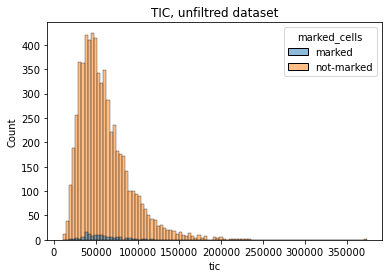

In [62]:
sns.histplot(adata.obs, x="tic", hue=cond_col)
plt.title("TIC, unfiltred dataset")
plt.savefig(plots_path / ("unfiltered_tic_%s.png"%cond_col), dpi=300)

We can see that TIC is different between conditions, which potentially can be a problem if difference is too big. Can also be a reason to go back to looking at raw data.

TIC plotted per well in log scale. Seems like there is one well-outlier. Possibly can be a reason to drop this well from analysis.

In [63]:
adata.obs.columns

Index(['center_x', 'center_y', 'cell_area', 'cell_sampling_area',
       'cell_sampling_ratio', 'cell_nearest_am_distance',
       'cell_nearest_cell_distance', 'centroid-0', 'centroid-1', 'bbox-0',
       ...
       'sum_intensity-Annotations', 'sampled_max_intensity-Annotations',
       'sampled_min_intensity-Annotations',
       'sampled_mean_intensity-Annotations',
       'sampled_median_intensity-Annotations',
       'sampled_sum_intensity-Annotations', 'dataset', 'marked_cells',
       'n_genes', 'tic'],
      dtype='object', length=101)

In [64]:
# sns.histplot(adata.obs, x="tic", hue="well", log_scale=True)
# plt.title("TIC, unfiltred dataset")
# plt.savefig(plots_path / ("unfiltered_tic_%s.png"%"well"), dpi=300)

In [65]:
# Filtering
lower_thresh = np.quantile(adata.obs["tic"], 0.1)
higher_thresh = np.quantile(adata.obs["tic"], 0.9)
print(lower_thresh, higher_thresh)
adata = adata[(adata.obs["tic"] > lower_thresh) & (adata.obs["tic"] < higher_thresh)]

29349.523046875 99348.32187500002


### Show the most abundant ions
Plot shows a fraction of intensity assigned to the ions in each cell. It is expected to see the main intracellular markers, such as adenine and other nucleotides, palmitate, PCs. Sometimes there is high abundance of phosphate, which either comes from fragmentation of intracellular molecules or has extracellular origin (not completely washed buffer), then it's worth considering to drop it from analysis.  
If datasets were just annotated with some database, then a lot of ions present in the file will be extracellular (easy to check by looking up in Metaspace). They need to be filtered out.

/Users/alberto-mac/miniconda3/envs/outerSpacem/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


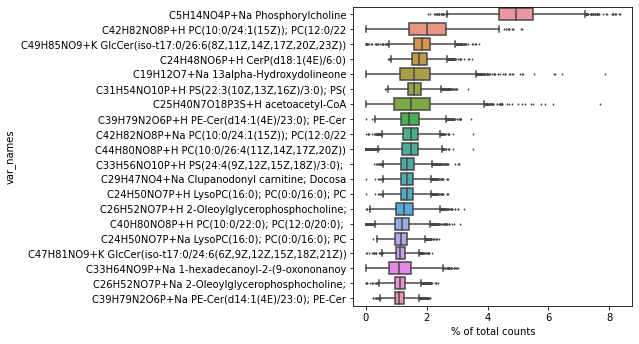

/Users/alberto-mac/miniconda3/envs/outerSpacem/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


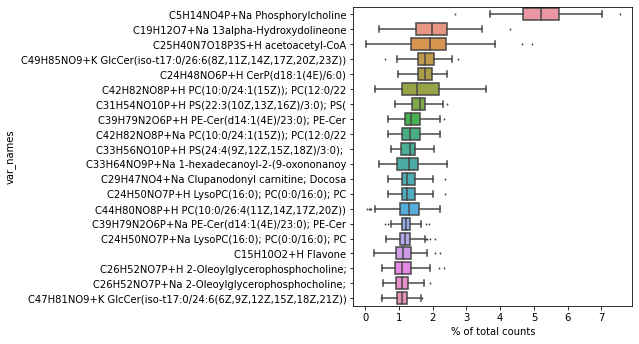

In [17]:
plot_highest_expr(adata, condition_col=cond_col, gene_symbols="var_names")

### Filter out ions with too low abundance

Ions present in just a handful of pixels will just be an additional source of noise. Also useful to take a look at median intensity over non-zero values

In [69]:
adata.var["log_total_intensity"] = np.log(adata.X.sum(axis=0))
adata.var["nonzero"] = np.count_nonzero(adata.X, axis=0)
adata.var["nonzero_ratio"] = np.count_nonzero(adata.X, axis=0) / adata.X.shape[0]

adata.layers["masked"]= np.ma.masked_less(adata.X, 1)
adata.var["median_nonzero_I"] = np.ma.median(adata.layers["masked"], axis=0)

/var/folders/xw/tcy65hq13818_4913hhp666h0000gq/T/ipykernel_78950/3617610938.py:1: RuntimeWarning: divide by zero encountered in log
  adata.var["log_total_intensity"] = np.log(adata.X.sum(axis=0))


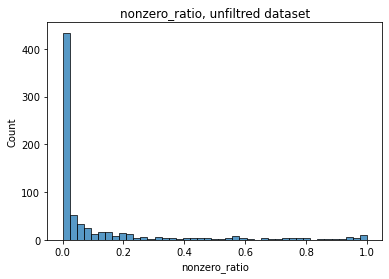

In [70]:
sns.histplot(adata.var, x="nonzero_ratio")
plt.title("nonzero_ratio, unfiltred dataset")
plt.savefig(plots_path / ("unfiltered_nonzero_ratio_%s.png"%cond_col), dpi=300)

A lot of ions from this database are completely not detected (typical with custom databases), while some are detected in every pixel (likely matrix ions). There is no universal threshold for this metric, so for now let's take only ions present in at least 5% of pixels.

In [71]:
# Here we do not do it, because it may play a role in our marked cells:
# Filtering
thresh = 0.01 
adata = adata[:, adata.var["nonzero_ratio"] > thresh]

#### Filter out things that are not appearing in marked cells

In [22]:
print(adata.X.shape)
adata_marked = adata[adata.obs["marked_cells"] == "marked"]
print(adata_marked.var.shape)
print(adata_marked.X.shape)
print(adata_marked.obs.shape)

(7584, 696)
(696, 17)
(140, 696)
(140, 100)


Trying to set attribute `.var` of view, copying.


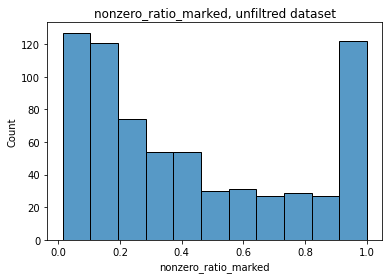

In [23]:

adata_marked.var["log_total_intensity_marked"] = np.log(adata_marked.X.sum(axis=0))
adata_marked.var["nonzero_marked"] = np.count_nonzero(adata_marked.X, axis=0)
adata_marked.var["nonzero_ratio_marked"] = np.count_nonzero(adata_marked.X, axis=0) / adata_marked.X.shape[0]

sns.histplot(adata_marked.var, x="nonzero_ratio_marked")
plt.title("nonzero_ratio_marked, unfiltred dataset")
plt.savefig(plots_path / ("unfiltered_nonzero_ratio_marked_%s.png"%cond_col), dpi=300)

In [24]:
### Filter out things that almost not appear in marked cells:
thresh = 0.05
# adata = adata[:, adata_marked.var["nonzero_ratio_marked"] > thresh]

Now check the final distribution:

<AxesSubplot:xlabel='nonzero_ratio', ylabel='Count'>

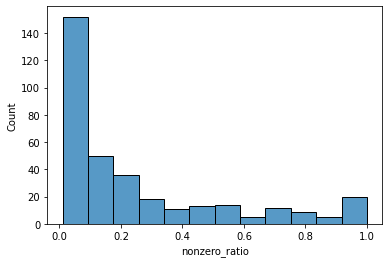

In [72]:
## For every annotation, how many cells are active in percentage
sns.histplot(adata.var, x="nonzero_ratio")

### Filter out extracellular ions

I think that the best way to do this step is to go through annotations manually and make a list of intracellular annotation IDs, because in the end there will be not so many of them (most likely under 100) and it's good to look at the data while it's not yet very clear how to analyze it. But for automatic analysis it's possible to use correlation distance (1 - spearman correlation coeffitient) and normalized manders colocalization coefficient (NMCC) [described here](https://docs.google.com/document/d/1nI1vIA3ijT8gc-tXlyoGJtKSbGwbxkU8KgK0v75Or6A/edit?usp=sharing).  

I prefer to make this step as permissive as possible and then remove some ions manually if any background ions remain.  

Correlation distance and NMCC are measures of how well cell mask matches ion image for each ion, so it is calculated per dataset. Let's use min value for correlation distance and max value for NMCC to pull together metrics calculated for different datasets. This way we take the best value, which ion managed to reach, and don't filter out ions, which might be present only in one condition.

For NMCC typical threshold is around 0.6-0.7, for correlation distance 0.8 - 0.9

In [26]:
nmcc_columns = [col for col in adata.var.columns if col.startswith("nmcc_score")]
corr_columns = [col for col in adata.var.columns if col.startswith("corr_dist")]

adata.var["nmcc_score"] = np.max(adata.var[nmcc_columns], axis=1)
adata.var["corr_dist"] = np.min(adata.var[corr_columns], axis=1)

Trying to set attribute `.var` of view, copying.


In [27]:
adata.var

,annotation_id,formula,adduct,ionFormula,ion,mz,msm,fdr,databases,moleculeNames,moleculeIds,moleculeNamesStr,var_names,log_total_intensity,nonzero,nonzero_ratio,median_nonzero_I,nmcc_score,corr_dist
C4H9O7P+Na,C4H9O7P+Na,C4H9O7P,+Na,C4H9O7PNa,C4H9O7P+Na+,222.997771,0.034286,0.5,"[[""CoreMetabolome"", ""v3""]]","[""D-Erythrose 4-phosphate""]","[""HMDB0001321""]",D-Erythrose 4-phosphate,C4H9O7P+Na D-Erythrose 4-phosphate,13.267199,3711,0.491849,137.771240,NaN,NaN
C5H14NO4P+Na,C5H14NO4P+Na,C5H14NO4P,+Na,C5H14NO4PNa,C5H14NO4P+Na+,206.055226,0.448761,0.1,"[[""CoreMetabolome"", ""v3""]]","[""Phosphorylcholine""]","[""HMDB0001565""]",Phosphorylcholine,C5H14NO4P+Na Phosphorylcholine,17.247801,7545,1.000000,4066.279053,NaN,NaN
C7H13O8P+H,C7H13O8P+H,C7H13O8P,+H,C7H14O8P,C7H13O8P+H+,257.042041,0.057573,0.2,"[[""SwissLipids"", ""2018-02-02""]]","[""PA(2:0/2:0)""]","[""SLM:000025480""]",PA(2:0/2:0),C7H13O8P+H PA(2:0/2:0),12.750214,2101,0.278463,149.260223,NaN,NaN
C7H14N2O3S+H,C7H14N2O3S+H,C7H14N2O3S,+H,C7H15N2O3S,C7H14N2O3S+H+,207.079750,0.131381,0.2,"[[""CoreMetabolome"", ""v3""]]","[""Glycyl-Methionine""]","[""HMDB0028847""]",Glycyl-Methionine,C7H14N2O3S+H Glycyl-Methionine,14.756255,5810,0.770046,399.012970,NaN,NaN
C7H14N2O4S+H,C7H14N2O4S+H,C7H14N2O4S,+H,C7H15N2O4S,C7H14N2O4S+H+,223.074665,0.021007,0.2,"[[""CoreMetabolome"", ""v3""]]","[""L-Cystathionine""]","[""HMDB0000099""]",L-Cystathionine,C7H14N2O4S+H L-Cystathionine,15.405735,6308,0.836050,713.233398,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C56H89O10P+Na,C56H89O10P+Na,C56H89O10P,+Na,C56H89O10PNa,C56H89O10P+Na+,975.608517,0.069769,0.2,"[[""SwissLipids"", ""2018-02-02""]]","[""PG(28:6(10Z,13Z,16Z,19Z,22Z,25Z)/22:5(7Z,10Z...","[""SLM:000036619"", ""SLM:000036610"", ""SLM:000039...","PG(28:6(10Z,13Z,16Z,19Z,22Z,25","C56H89O10P+Na PG(28:6(10Z,13Z,16Z,19Z,22Z,25",13.027156,2193,0.290656,194.127640,NaN,NaN
C56H99NO9+Na,C56H99NO9+Na,C56H99NO9,+Na,C56H99NO9Na,C56H99NO9+Na+,952.721166,0.014697,0.5,"[[""SwissLipids"", ""2018-02-02""]]","[""GlcCer(t18:0/32:6(14Z,17Z,20Z,23Z,26Z,29Z))""]","[""SLM:000399083""]","GlcCer(t18:0/32:6(14Z,17Z,20Z,23Z,26Z,29Z))","C56H99NO9+Na GlcCer(t18:0/32:6(14Z,17Z,20Z,23Z...",11.926723,902,0.119549,159.419998,NaN,NaN
C57H99O7P+Na,C57H99O7P+Na,C57H99O7P,+Na,C57H99O7PNa,C57H99O7P+Na+,949.702024,0.181857,0.2,"[[""SwissLipids"", ""2018-02-02""]]","[""PA(P-18:1(9Z)/36:6(18Z,21Z,24Z,27Z,30Z,33Z))...","[""SLM:000047114"", ""SLM:000046874"", ""SLM:000045...","PA(P-18:1(9Z)/36:6(18Z,21Z,24Z","C57H99O7P+Na PA(P-18:1(9Z)/36:6(18Z,21Z,24Z",13.972692,3529,0.467727,310.185150,NaN,NaN
C57H101O7P+Na,C57H101O7P+Na,C57H101O7P,+Na,C57H101O7PNa,C57H101O7P+Na+,951.717674,0.091886,0.2,"[[""SwissLipids"", ""2018-02-02""]]","[""PA(P-24:0/30:6(12Z,15Z,18Z,21Z,24Z,27Z))"", ""...","[""SLM:000047658"", ""SLM:000499630"", ""SLM:000499...","PA(P-24:0/30:6(12Z,15Z,18Z,21Z","C57H101O7P+Na PA(P-24:0/30:6(12Z,15Z,18Z,21Z",12.584142,1532,0.203048,177.270920,NaN,NaN


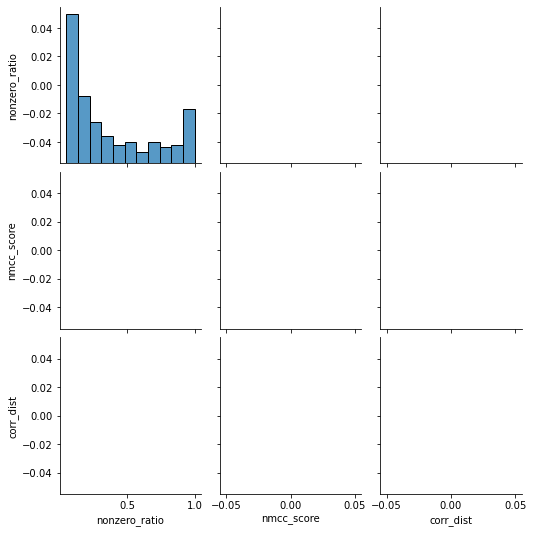

In [28]:
sns.pairplot(adata.var, vars=["nonzero_ratio", "nmcc_score", "corr_dist"])
plt.savefig(plots_path / ("pairplot_intracellular_metrics.png"), dpi=300)

In [29]:
# Filtering
nmcc_thresh = 0.6
corr_thresh = 0.9

# Skip this because we are not doing pixel analysis:
# adata = adata[:, (adata.var["nmcc_score"] > nmcc_thresh) & (adata.var["corr_dist"] < corr_thresh)]

### Filter cells by the number of detected intracellular ions

Some cells can be actually background or just have bad signal for some reason, so it's worth checking, how many molecules are detected in each cell and possibly filter out ones that are not good.

In [26]:
adata.obs["tic_intra"] = adata.X.sum(axis=1)
adata.obs["nonzero"] = np.count_nonzero(adata.X, axis=1)
adata.obs["nonzero_ratio"] = np.count_nonzero(adata.X, axis=1) / adata.X.shape[1]

Trying to set attribute `.obs` of view, copying.


In [27]:
adata.var.columns

Index(['annotation_id', 'formula', 'adduct', 'ionFormula', 'ion', 'mz', 'msm',
       'fdr', 'databases', 'moleculeNames', 'moleculeIds', 'moleculeNamesStr',
       'var_names', 'log_total_intensity', 'nonzero', 'nonzero_ratio',
       'median_nonzero_I'],
      dtype='object')

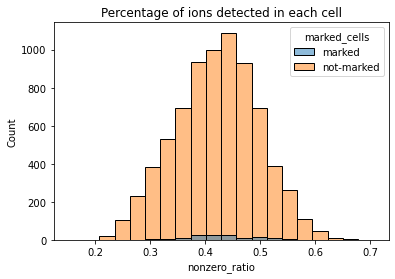

In [28]:
sns.histplot(adata.obs, x="nonzero_ratio", hue=cond_col, bins=20)
plt.title("Percentage of ions detected in each cell")
plt.savefig(plots_path / ("unfiltered_nonzero_per_cell_%s.png"%cond_col), dpi=300)

In this case control has a bit better detection, consistent with higher TIC.  

In [29]:
# Filtering
intra_ratio_thresh = 0.31
adata = adata[adata.obs["nonzero_ratio"] > intra_ratio_thresh]

### Show cells TIC...? 
Nothing done here

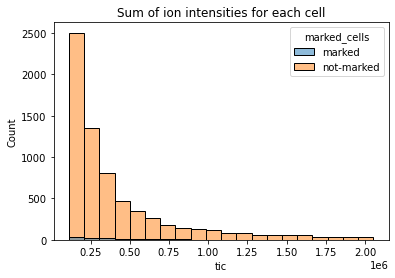

In [30]:
sns.histplot(adata.obs, x="tic", hue=cond_col, bins=20)
plt.title("Sum of ion intensities for each cell")
plt.savefig(plots_path / ("unfiltered_tic_intra_per_cell_%s.png"%cond_col), dpi=300)

/Users/alberto-mac/miniconda3/envs/outerSpacem/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


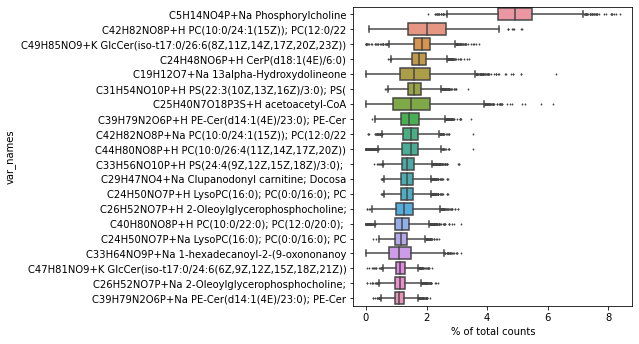

/Users/alberto-mac/miniconda3/envs/outerSpacem/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


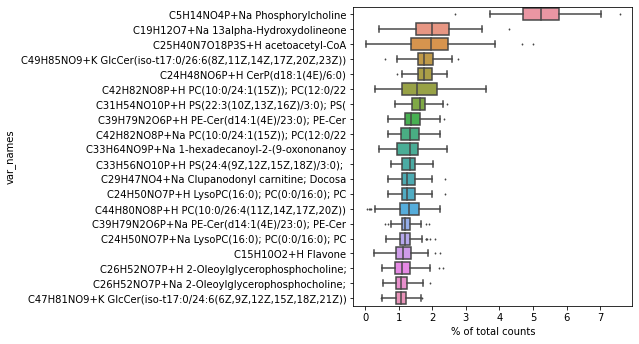

In [31]:
plot_highest_expr(adata, cond_col, "_filtered", gene_symbols="var_names")

### Plot PCA

PCA can be used to check if there are obvious clusters in the data and what ions describe variability in the dataset.  
The most common problem that I encountered at this step is that some outlier cells were not filtered out and were defining variation along one or more principal components, then I returned to previous steps and made thresholds more strict.  

Another issue that I saw was that 99% of variation was determined by the first PC, and from the loadings plot I could see that it's one or two ions defining this principal component. In that case it's worth inspecting, what are those ions, and removing them from further analysis.

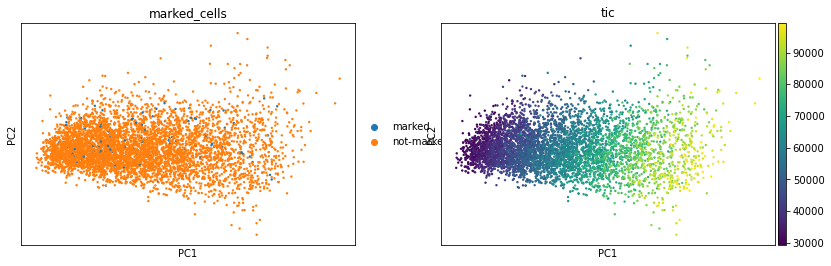

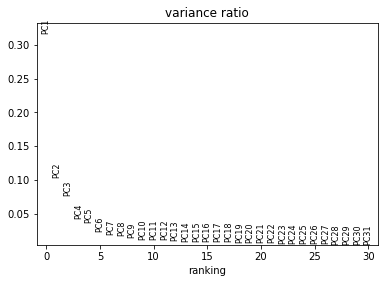

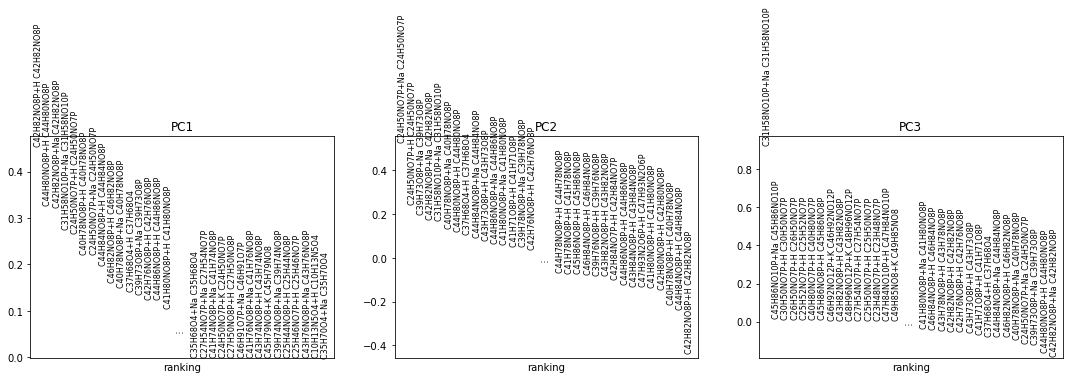

In [74]:
# Copy adata and assign index of the dataset to the molecule name strings to get annotated PC components
adata_names = adata.copy()
adata_names.var_names = adata.var.var_names

sc.pp.pca(adata_names)

# Plot PCA
sc.pl.pca(adata_names, color=[cond_col, "tic"], save="_filtered.png", show=True)

# Plot PCA variance
sc.pl.pca_variance_ratio(adata_names, save="_filtered.png", show=True)

# Plot PCA ion importance
sc.pl.pca_loadings(adata_names, components = '1,2,3', save="_filtered.png", show=True)


### Normalization

Normalization is dividing the intensities of all ions by some value calculated per cell, aiming to get rid of some technical effect and make samples more comparable.  

- TIC from imzML - aims to compensate for overall difference between how mass spec worked (whatever it means)
- "Intracellular TIC" - divide by the sum over intensities of annotated ions for each cell (what `scanpy.pp.normalize_total` does). If normalization is done before any filtering and database included a lot of matrix ions, it will be close to the TIC from imzML. If done in the end, when there are ~100 ions left or so, then all further analysis will be answering question "does proportion between these molecules change?"
- Some individual ion - if there is some molecule, which should 100% stay the same in all conditions and has high intensity, it might be used for normalization. I don't think it's a good option, because measurements are very noisy and doing this will make data even more noisy.

In [75]:
adata_norm = adata.copy()

# Normalize by TIC
# adata_norm.X  = np.divide(adata_norm.X, np.array(adata_norm.obs["tic"])[:, None])

# Scanpy norm
sc.pp.normalize_total(adata, key_added='tic')

/Users/alberto-mac/miniconda3/envs/outerSpacem/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


### Save filtered adata

It is convenient to save adata at this point, because usually people try several filtering and normalization options and then decide based on if differential expression and clustering make sense or not.

In [76]:
adata_norm.write(normalized_dataset_path)